In [1]:
import random
import pickle
import math
import nltk

import pandas as pd
import numpy as np
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Import in all the data

In [2]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))

df = pd.read_csv('..\data\data_lem.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
#lowercase
a = [col.lower() for col in df.columns]
df.columns = a
#preview
df.head(10)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_16724/3447199195.py:3: DeprecationWarning: invalid escape sequence \d
  df = pd.read_csv('..\data\data_lem.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)


,email,lemmatized,spam
0,"[christmas, tree, farm, pictures]","[christmas, tree, farm, picture]",False
1,"[calpine, daily, gas, nomination, calpine, dai...","[calpine, daily, gas, nomination, calpine, dai...",False
2,"[mcmullen, gas, jackie, since, inlet, river, p...","[mcmullen, gas, jackie, since, inlet, river, p...",False
3,"[meter, 1517, jan, 1999, george, need, followi...","[meter, 1517, jan, 1999, george, need, follow,...",False
4,"[king, ranch, two, fields, gas, difficulty, un...","[king, ranch, two, field, gas, difficulty, uni...",False
5,"[entex, transistion, purpose, email, recap, ki...","[entex, transistion, purpose, email, recap, ki...",False
6,"[unify, close, schedule, following, close, sch...","[unify, close, schedule, following, close, sch...",False
7,"[meter, 1431, nov, 1999, aimee, sitara, deal, ...","[meter, 1431, nov, 1999, aimee, sitara, deal, ...",False
8,"[texas, log, name, home, pager, george, grant,...","[texas, log, name, home, pager, george, grant,...",False
9,"[meter, 1441, falfurrias, daren, need, help, r...","[meter, 1441, falfurrias, daren, need, help, r...",False


In [3]:
'{:,}'.format(len(df))

'24,932'

Start creating CV sets. We are going to perform 10-fold CV.

We start by shuffling the data

In [67]:
#set seed
random.seed(a=42)
#rearrange index
ind = list(range(0,len(df)))
random.shuffle(ind)
ind[:10] 

[3656, 22400, 22323, 3126, 13821, 12909, 24764, 13486, 21779, 1132]

In [68]:
#create a rearranged df. we use only use lemmatized emails from now on
temp_df = df.iloc[ind][['lemmatized','spam']]
temp_df.head()

,lemmatized,spam
3656,"[logistics, sycamore, meeting, chelmsford, nex...",False
22400,"[surprise, girlfriend, night, make, feel, well...",True
22323,"[1842, radio, 1924, martha, stewartdo, city, n...",True
3126,"[welcome, online, affair, network, massive, ci...",True
13821,"[longlasting, erection, new, clalls, softtabs,...",True


We continue with an 80:20 split for train:test. Our training set is then split into 10-folds.

In [69]:
#our dataframe does not perfectly divide
len(temp_df)/5

4986.4

In [70]:
#we use the floor function for better a better divisor of data
five_floor = math.floor(len(temp_df)/5)
five_floor

4986

In [71]:
#we take everything after the '80th percentile' as test set
#this will be 2 entries longer than our other sets
test_df = temp_df.iloc[4*five_floor:] 
len(test_df), test_df.head()

(4988,
                                               lemmatized   spam
 3910   [pres, delainy, sorry, vince, please, use, fil...  False
 16837  [msnbc, rate, hit, year, low, 28940, hundred, ...   True
 5694   [internet, news, feed, executive, dfvht, final...   True
 21530  [parcelas, pucon, puede, ver, aviso, haga, cli...   True
 2440   [stop, pay, pay, per, view, channel, fri, apr,...   True)

In [72]:
#we take everything up to '80th percentile' as train set
train_df = temp_df.iloc[:4*five_floor]
len(train_df), train_df.tail() #checking that there's no entry overlap with test_df

(19944,
                                               lemmatized   spam
 18238  [entrust, visual, identity, think, breathe, ne...   True
 9145   [uluslararasi, telefon, grmelernde, byk, tasar...   True
 14041  [iagra, fashion, find, new, clalls, softtabs, ...   True
 1331   [south, hampton, refining, add, deal, 541123, ...  False
 23722  [surf, charset, big, marketing, exhibition, of...   True)

In [73]:
ten_floor = math.floor(len(train_df)/10)
ten_floor

1994

Now we shuffle the train_df as we shuffled the original df before (this is mainly to create a new set of indices)

In [82]:
#set seed
random.seed(a=42)
#rearrange index
ind = list(train_df.index)
random.shuffle(ind)
ind[:10] 

[14595, 16896, 5964, 13805, 6016, 14063, 15617, 5336, 4643, 17295]

We not create our 10 splits of the training dataset

In [83]:
train_df = train_df.loc[ind]
train_df.head()

,lemmatized,spam
14595,"[good, idea, original, replica, rolex, handwat...",True
16896,"[vehicle, make, noise, aak, protect, financial...",True
5964,"[claim, free, home, depot, gift, card, 1000, v...",True
13805,"[brother, cop, pain, finish, pain, husband, pa...",True
6016,"[graphic, software, available, cheap, oem, ver...",True


In [88]:
for i in range(0,10):
    start = ten_floor*i
    end = ten_floor*(i+1)

    #we create 9 equal datafrmes
    if i < 9:
        a = ind[start:end]
    else:
        a = ind[start:] #10th dataframes is larger by 4 entries
        
    locals()['df_{}'.format(i)] = train_df.loc[a][['lemmatized','spam']]

In [89]:
df_0

,lemmatized,spam
14595,"[good, idea, original, replica, rolex, handwat...",True
16896,"[vehicle, make, noise, aak, protect, financial...",True
5964,"[claim, free, home, depot, gift, card, 1000, v...",True
13805,"[brother, cop, pain, finish, pain, husband, pa...",True
6016,"[graphic, software, available, cheap, oem, ver...",True
...,...,...
14653,"[new, twc, get, one, relieve, pajn, palazzo, n...",True
11199,"[start, date, hourahead, hour, start, date, ho...",False
3612,"[vince, congratulation, promotion, regard]",False
19716,"[prescription, med, door, among, net, approve,...",True


In [90]:
df_9

,lemmatized,spam
20646,"[kern, county, power, plant, michelle, great, ...",False
4891,"[enron, india, database, sandeep, summarize, h...",False
1446,"[enron, hpl, actuals, january, 2001, teco, tap...",False
7044,"[hotlist, louise, attach, hotlist, base, last,...",False
18594,"[hate, type, get, ibm, product, talk, instead,...",True
...,...,...
17010,"[sometimes, always, like, idea, chick, horse, ...",True
6063,"[claim, free, home, depot, gift, card, 1000, v...",True
6672,"[undelivered, mail, return, sender, postfix, p...",True
8215,"[gmm, oct, please, find, attach, global, marke...",False


Now that we have 10 dataframes, we will create 10 different training/validation splits.

We will have 
 - split 0: df_0 = validation, df_1:df_9 = train
 - split 1: df_1 = validation, df_0, df_2:df_9 = train
 - ... and so on.
 


In [91]:
for i in range(0,10):
    ks = []
    #we create val_df_i out of df_i
    locals()['val_df_{}'.format(i)] = locals()['df_{}'.format(i)]
    
    #we create a list of all df_k where k!=i
    for k in range(0,10):
        if k!=i:
            df_k = locals()['df_{}'.format(k)] 
            ks.append(df_k)
            
    #concatenate df_k's into train_df_i
    locals()['train_df_{}'.format(i)] = pd.concat(ks)

In [92]:
#preview
val_df_0, train_df_0

(                                              lemmatized   spam
 14595  [good, idea, original, replica, rolex, handwat...   True
 16896  [vehicle, make, noise, aak, protect, financial...   True
 5964   [claim, free, home, depot, gift, card, 1000, v...   True
 13805  [brother, cop, pain, finish, pain, husband, pa...   True
 6016   [graphic, software, available, cheap, oem, ver...   True
 ...                                                  ...    ...
 14653  [new, twc, get, one, relieve, pajn, palazzo, n...   True
 11199  [start, date, hourahead, hour, start, date, ho...  False
 3612          [vince, congratulation, promotion, regard]  False
 19716  [prescription, med, door, among, net, approve,...   True
 18321  [one, stop, store, best, levitra, buy, drug, s...   True
 
 [1994 rows x 2 columns],
                                               lemmatized   spam
 14389  [fwd, omg, look, loa, overdid, oomiak, micella...   True
 20982  [lose, weight, new, weightloss, hello, special...   Tr

Now we create 10 dictioanries for each of our training sets.

In [93]:
for i in range(0,10):
    #create dictionary_i out of train_df_i
    locals()['dictionary_{}'.format(i)] = gensim.corpora.Dictionary(locals()['train_df_{}'.format(i)].lemmatized)

In [94]:
#we have a preview of one of our dictionaries
count = 0

for index,word in dictionary_1.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break

print()
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 119
1 205
2 229
3 3169
4 3340
5 837
6 882
7 alain
8 audemars
9 bargain
10 bmw

dictionary_1 length 102,601


### Revisit intuition on this

For each dictionary, we drop words which occur in less than 15 documents and which appear in more than 50% of all documents. The intuition is that anything too common is likely to be prevalent in many topics and thus uninformative, while anything very uncommon may not provide enough information and have little impact on predicting the topic of a new document.

In [95]:
for i in range(0,10):
    #filter extremes for dictionary_i
    locals()['dictionary_{}'.format(i)].filter_extremes(no_below=15, no_above=0.5)

We look at two dictionaries to see how they look like now

In [101]:
count = 0

for index,word in dictionary_0.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 click
1 contribute
2 despot
3 dislike
4 dock
5 drift
6 feel
7 fwd
8 hijack
9 intensify
10 look
dictionary_1 length 9,202


In [102]:
count = 0

for index,word in dictionary_4.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_4 length {:,}'.format(len(dictionary_4)))

0 119
1 205
2 229
3 alain
4 audemars
5 bargain
6 bmw
7 breguet
8 breitling
9 bvlgari
10 cartier
dictionary_4 length 9,280


We compare the words in each dictionary with one another. The following comparison only compares dictionary_0 with other dictionaries; it is debatable whether looking at all possible combinations is useful or not but the following is only illustrative and we need not look through every combination as that can be computationally expensive.

In [98]:
for i in range(1,10):
    same = 0
    
    for (index_j, word_j) in dictionary_0.iteritems():
        #compare dictionary_0 with dictionary_i=1,...,9
        for (index_k, word_k) in locals()['dictionary_{}'.format(i)].iteritems():
            #keep count of how many words are the same
            if word_j == word_k:
                same +=1

    print('{:,} words ({:.2f}%) in dictionary_0 exist in dictionary_{}'.format(same,100*same/len(dictionary_0),i))

8,881 words (96.57%) in dictionary_0 exist in dictionary_1
8,866 words (96.41%) in dictionary_0 exist in dictionary_2
8,923 words (97.03%) in dictionary_0 exist in dictionary_3
8,917 words (96.97%) in dictionary_0 exist in dictionary_4
8,801 words (95.70%) in dictionary_0 exist in dictionary_5
8,889 words (96.66%) in dictionary_0 exist in dictionary_6
8,831 words (96.03%) in dictionary_0 exist in dictionary_7
8,850 words (96.24%) in dictionary_0 exist in dictionary_8
8,896 words (96.74%) in dictionary_0 exist in dictionary_9


It seems that our dictionaries are very similar (which is expected as a lot of the df rows are shared) but this is something to keep in mind if results end up looking very similar as this could imply low variance between data splits.

Next, we just take a quick look at how much spam is in each df_i compared to our original df as a sanity check that there is a representative amount in each split.

In [103]:
for i in range(0,10):
    tmp_df = locals()['df_{}'.format(i)]
    
    p = sum(tmp_df.spam)/len(tmp_df)
    p = p*100
    
    print('{:.2f}% of all emails are spam in df_{}'.format(p,i))
    
print()
print('{:.2f} of all emails are spam in test df'.format(100*sum(test_df.spam)/len(test_df)))
print('{:.2f}% of all emails are spam in original df'.format(100*sum(df.spam)/len(df)))

59.43% of all emails are spam in df_0
60.53% of all emails are spam in df_1
60.38% of all emails are spam in df_2
61.94% of all emails are spam in df_3
61.69% of all emails are spam in df_4
59.08% of all emails are spam in df_5
60.73% of all emails are spam in df_6
62.04% of all emails are spam in df_7
62.84% of all emails are spam in df_8
60.31% of all emails are spam in df_9

62.29 of all emails are spam in test df
61.17% of all emails are spam in original df


Create 10 corpora from each training dataframe's dictionary

In [104]:
for i in range(0,10):
    dct = locals()['dictionary_{}'.format(i)]
    locals()['bow_corpus_{}'.format(i)] = [dct.doc2bow(doc) for doc in locals()['train_df_{}'.format(i)].lemmatized]

## Creating LDA Model 0

We now run our model for df_0 to take an initial look before doing the same for all the other dataframes.

We start with `num_topic=48` as the previous Assessment 3 [cite] found this to be optimal for number of topics between 1 and 50. However, we will be exploring this more closely later on.

Assigning `minimum_probability=0.0` allows us to see the probability of a document being in each topic no matter how small. We will be making use of this later on so we start using it here for the sake of consistency.

<b>Note:</b> `workers=5` is set to be `number of CPU cores - 1`. You may want to adjust this based on your computer/device.

In [146]:
lda_model_0 = gensim.models.LdaMulticore(bow_corpus_0, num_topics=48, id2word=dictionary_0,minimum_probability=1/1000,
                                         passes=2, workers=5,random_state=42)

Creating a display for our LDA model and visualising it

In [106]:
lda_display_0 = gensimvis.prepare(lda_model_0, bow_corpus_0, dictionary_0, mds='mmds')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [107]:
pyLDAvis.display(lda_display_0, template_type='notebook')

A natural approach may be to only assign 2 topics to the model and hope that these correspond to spam and ham.

Instead, we continue with 48 topics (for now) and instead assess how much spam exists within each topic and assign a threshold (e.g. 50%) where if the topic has more spam than the threshold, we label it as a 'spam topic'.

In [147]:
train_df_0.head()

,lemmatized,spam
14389,"[fwd, omg, look, loa, overdid, oomiak, micella...",True
20982,"[lose, weight, new, weightloss, hello, special...",True
24481,"[sexually, explicit, lifetime, membership, fea...",True
18997,"[get, order, anything, sell, million, customer...",True
2484,"[patent, thad, madrid, ble, filter, allow, rec...",True


In [156]:
b = train_df_0.iloc[42].lemmatized
b

['holiday',
 'daily',
 'position',
 'report',
 'report',
 'due',
 'christmas',
 'new',
 'year',
 'holiday',
 'nymex',
 'close',
 'monday',
 'december',
 'monday',
 'january',
 '2001',
 'nymex',
 'also',
 'close',
 'early',
 'friday',
 'december',
 'friday',
 'december',
 'consolidated',
 'dpr',
 'report',
 'follow',
 'wednesday',
 'december',
 'dpr',
 'december',
 'publish',
 'thursday',
 'december',
 'dpr',
 'december',
 'combine',
 'publish',
 'friday',
 'december',
 'dpr',
 'december',
 'publish',
 'tuesday',
 'january',
 'dpr',
 'friday',
 'december',
 'normal',
 'month',
 'end',
 'schedule',
 'although',
 'combine',
 'report',
 'still',
 'need',
 'data',
 'day',
 'correctly',
 'assess',
 'data',
 'limit',
 'please',
 'call',
 'question',
 'comment',
 '54541']

In [157]:
max(lda_model_0[dictionary_0.doc2bow(b)],key=lambda item:item[1])

(33, 0.9482938)

In [158]:
lda_model_0[dictionary_0.doc2bow(b)]

[(18, 0.038050175), (33, 0.9482537)]

In [150]:
lda_model_0.show_topic(41,10)

[('adobe', 0.03710142),
 ('enron', 0.011538176),
 ('2004', 0.009866196),
 ('software', 0.008337614),
 ('professional', 0.008290201),
 ('studio', 0.0073579),
 ('photoshop', 0.0067415177),
 ('pro', 0.006522819),
 ('premiere', 0.006424251),
 ('company', 0.005814137)]

This seems potentially a little worrying as the email we just checked is labelled spam and seems to be about selling Italian Rolexes raather than any of the top 10 words for this topic.

In [112]:
train_df_0.head()

,lemmatized,spam
14389,"[fwd, omg, look, loa, overdid, oomiak, micella...",True
20982,"[lose, weight, new, weightloss, hello, special...",True
24481,"[sexually, explicit, lifetime, membership, fea...",True
18997,"[get, order, anything, sell, million, customer...",True
2484,"[patent, thad, madrid, ble, filter, allow, rec...",True


In [134]:
#dictionary counting spam / ham in each topic initialised with 0
topic_spam = {topic:0 for topic in list(range(0,48))}
topic_ham = {topic:0 for topic in list(range(0,48))}

#loop throuh documents
for i in range(0,len(train_df_0)):
    
    doc = train_df_0.iloc[i]
    spam = int(doc.spam)    #gives us 1 if spam, 0 otherwise
    lem = doc.lemmatized
    
    prob_dist = lda_model_0[dictionary_0.doc2bow(lem)]    #prob distribution of document
    topic = max(prob_dist, key=lambda item:item[1])[0]    #topic of document
    
    if spam:
        topic_spam[topic] += 1
    else:
        topic_ham[topic] += 1

In [135]:
spam_percentages = {topic:0 for topic in list(range(0,48))}

for topic in topic_spam:
    total_ham = topic_ham[topic]
    total_spam = topic_spam[topic]
    
    spam_percentages[topic] = total_spam/(total_spam + total_ham)

In [136]:
spam_topics = []

for topic in spam_percentages:
    if spam_percentages[topic]>0.5:
        spam_topics.append(topic)
        print(topic,spam_percentages[topic])

0 0.8927038626609443
3 0.7100436681222707
5 0.5541666666666667
7 0.7191489361702128
8 0.9949022939677146
10 0.6862068965517242
13 0.6116504854368932
14 0.9659090909090909
16 0.8780487804878049
17 0.9545454545454546
19 0.68
21 0.9035087719298246
24 0.680672268907563
25 0.8955223880597015
26 0.7565217391304347
27 0.994750656167979
28 0.95
30 0.9333333333333333
31 0.8754716981132076
32 0.9608482871125612
34 0.5695364238410596
35 0.8087855297157622
37 0.5207373271889401
38 0.5782828282828283
39 0.7523809523809524
40 0.8363636363636363
41 0.8823529411764706
42 0.7745358090185677
43 0.8892045454545454
45 0.7797927461139896
46 0.936046511627907


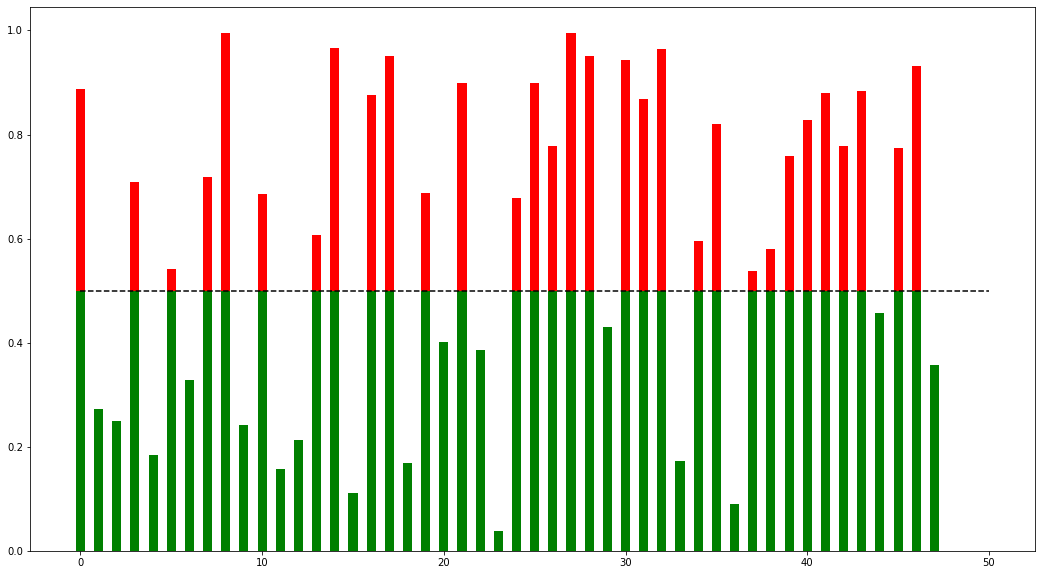

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# some example data
threshold = 0.5
values = np.array(list(spam_percentages.values()))
x = range(len(values))

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it
fig, ax = plt.subplots(figsize=(18,10))
ax.bar(x, below_threshold, 0.5, color="g")
ax.bar(x, above_threshold, 0.5, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 50], [threshold, threshold], "k--")

In [117]:
val_df_0

,lemmatized,spam
14595,"[good, idea, original, replica, rolex, handwat...",True
16896,"[vehicle, make, noise, aak, protect, financial...",True
5964,"[claim, free, home, depot, gift, card, 1000, v...",True
13805,"[brother, cop, pain, finish, pain, husband, pa...",True
6016,"[graphic, software, available, cheap, oem, ver...",True
...,...,...
14653,"[new, twc, get, one, relieve, pajn, palazzo, n...",True
11199,"[start, date, hourahead, hour, start, date, ho...",False
3612,"[vince, congratulation, promotion, regard]",False
19716,"[prescription, med, door, among, net, approve,...",True


In [139]:
def predictSpam(input_df, model=lda_model_0, dictionary=dictionary_0, spam_topics=spam_topics):
    #create vector of zeros
    y_pred = [0] * len(input_df)
    #vector with 1 for spam 0 for ham
    y_actual = list(input_df.spam.apply(int))

    for i in range(len(input_df)):
        doc = input_df.iloc[i]
        lem = doc.lemmatized
        
        #find probability distribution of document
        prob_dist = model[dictionary.doc2bow(lem)]
        topic = max(prob_dist, key=lambda item:item[1])[0]

        if topic in spam_topics:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
            
    return y_pred, y_actual

In [119]:
y_pred, y_actual = predictSpam(val_df_0, lda_model_0, dictionary_0, spam_topics)

In [120]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_eval(y_actual,y_pred):
    
    C = confusion_matrix(y_actual,y_pred)
    
    print("Confusion Matrix")
    print(C)
    
    print()
    
    print('Classification report')
    print(classification_report(y_actual, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [121]:
classification_eval(y_actual, y_pred)

Confusion Matrix
[[ 616  193]
 [ 107 1078]]

Classification report
              precision    recall  f1-score   support

      Normal      0.852     0.761     0.804       809
        Spam      0.848     0.910     0.878      1185

    accuracy                          0.850      1994
   macro avg      0.850     0.836     0.841      1994
weighted avg      0.850     0.850     0.848      1994



In [122]:
y_pred_test, y_actual_test = predictSpam(test_df)

In [123]:
classification_eval(y_actual_test,y_pred_test)

Confusion Matrix
[[1392  489]
 [ 295 2812]]

Classification report
              precision    recall  f1-score   support

      Normal      0.825     0.740     0.780      1881
        Spam      0.852     0.905     0.878      3107

    accuracy                          0.843      4988
   macro avg      0.838     0.823     0.829      4988
weighted avg      0.842     0.843     0.841      4988



### Checking Other Folds

In [124]:
for i in range(1,10):
    corpus = locals()['bow_corpus_{}'.format(i)]
    dictionary = locals()['dictionary_{}'.format(i)]
    
    locals()['lda_model_{}'.format(i)] = gensim.models.LdaMulticore(corpus, num_topics=48, id2word=dictionary,minimum_probability=0.0,
                                                                    passes=2, workers=5,random_state=42)

In [125]:
for i in range(1,10):
    #dictionary counting spam / ham in each topic initialised with 0
    topic_spam = {topic:0 for topic in list(range(0,48))}
    topic_ham = {topic:0 for topic in list(range(0,48))}
    
    #fetch train_df_i, lda_model_i, dictionary_i
    train_df_i = locals()['train_df_{}'.format(i)]
    lda_model_i = locals()['lda_model_{}'.format(i)]
    dictionary_i = locals()['dictionary_{}'.format(i)]
    
    #loop throuh documents
    for k in range(0,len(train_df_i)):

        doc = train_df_i.iloc[k]
        spam = int(doc.spam)    #gives us 1 if spam, 0 otherwise
        lem = doc.lemmatized
        
        

        prob_dist = lda_model_i[dictionary_i.doc2bow(lem)]    #prob distribution of document
        topic = max(prob_dist, key=lambda item:item[1])[0]    #topic of document

        if spam:
            topic_spam[topic] += 1
        else:
            topic_ham[topic] += 1
            
        
    locals()['topic_spam_{}'.format(i)] = topic_spam
    locals()['topic_ham_{}'.format(i)] = topic_ham

In [126]:
for i in range(1,10):
    spam_percentages = {topic:0 for topic in list(range(0,48))}
    
    topic_ham_i = locals()['topic_ham_{}'.format(i)]
    topic_spam_i = locals()['topic_spam_{}'.format(i)]

    for topic in topic_spam_i:
        total_ham = topic_ham_i[topic]
        total_spam = topic_spam_i[topic]

        spam_percentages[topic] = total_spam/(total_spam + total_ham)
        
    locals()['spam_percentages_{}'.format(i)] = spam_percentages

In [127]:
for i in range(1,10):
    spam_topics = []

    spam_percentages_i = locals()['spam_percentages_{}'.format(i)]
    for topic in spam_percentages_i:
        if spam_percentages_i[topic]>0.5:
            spam_topics.append(topic)
            
    locals()['spam_topics_{}'.format(i)] = spam_topics

In [140]:
for i in range(1,10):
    val_df_i = locals()['val_df_{}'.format(i)]
    lda_model_i = locals()['lda_model_{}'.format(i)]
    dictionary_i = locals()['dictionary_{}'.format(i)]
    spam_topics_i = locals()['spam_topics_{}'.format(i)]
    
    y_pred, y_actual = predictSpam(val_df_i, lda_model_i, dictionary_i,spam_topics_i)
    
    locals()['y_pred_{}'.format(i)] = y_pred
    locals()['y_actual_{}'.format(i)] = y_actual

In [141]:
for i in range(1,10):
    print('Running Fold {} scores'.format(i))
    print()
    y_actual = locals()['y_actual_{}'.format(i)]
    y_pred = locals()['y_pred_{}'.format(i)]
    
    classification_eval(y_actual,y_pred)
    
    print('-'*30)

Running Fold 1 scores

Confusion Matrix
[[ 582  205]
 [  83 1124]]

Classification report
              precision    recall  f1-score   support

      Normal      0.875     0.740     0.802       787
        Spam      0.846     0.931     0.886      1207

    accuracy                          0.856      1994
   macro avg      0.860     0.835     0.844      1994
weighted avg      0.857     0.856     0.853      1994

------------------------------
Running Fold 2 scores

Confusion Matrix
[[ 606  184]
 [ 137 1067]]

Classification report
              precision    recall  f1-score   support

      Normal      0.816     0.767     0.791       790
        Spam      0.853     0.886     0.869      1204

    accuracy                          0.839      1994
   macro avg      0.834     0.827     0.830      1994
weighted avg      0.838     0.839     0.838      1994

------------------------------
Running Fold 3 scores

Confusion Matrix
[[ 606  153]
 [  75 1160]]

Classification report
              

In [145]:
spam_topics_9

[0,
 3,
 7,
 8,
 14,
 17,
 18,
 19,
 20,
 21,
 24,
 26,
 28,
 29,
 30,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 42,
 43,
 44,
 45,
 46,
 47]

In [143]:
aa = prob_dist
aa

[(0, 0.00025121187),
 (1, 0.00025121187),
 (2, 0.00025121187),
 (3, 0.3258817),
 (4, 0.00025121187),
 (5, 0.00025121187),
 (6, 0.00025121187),
 (7, 0.00025121187),
 (8, 0.00025121187),
 (9, 0.00025121187),
 (10, 0.00025121187),
 (11, 0.00025121187),
 (12, 0.00025121187),
 (13, 0.00025121187),
 (14, 0.00025121187),
 (15, 0.00025121187),
 (16, 0.00025121187),
 (17, 0.00025121187),
 (18, 0.00025121187),
 (19, 0.00025121187),
 (20, 0.00025121187),
 (21, 0.00025121187),
 (22, 0.00025121187),
 (23, 0.56025577),
 (24, 0.00025121187),
 (25, 0.00025121187),
 (26, 0.00025121187),
 (27, 0.00025121187),
 (28, 0.00025121187),
 (29, 0.00025121187),
 (30, 0.00025121187),
 (31, 0.00025121187),
 (32, 0.00025121187),
 (33, 0.00025121187),
 (34, 0.00025121187),
 (35, 0.00025121187),
 (36, 0.00025121187),
 (37, 0.00025121187),
 (38, 0.00025121187),
 (39, 0.015686678),
 (40, 0.00025121187),
 (41, 0.00025121187),
 (42, 0.0871226),
 (43, 0.00025121187),
 (44, 0.00025121187),
 (45, 0.00025121187),
 (46, 0.000

We tried optimising but took too long and this is not the main goal of this assignment

In [ ]:
# for i in range(0,10):
    
#     for k in range(1,150):
#         lda_model_i = lda.gensim(topics=k)
        
#         spam_percentage = {}
        
#         for t in [0.5,0.53,...,0.62]:
#             if spam_percentage[topic]>t
#             spam_topic
            
#             val_df
            
#             calculate_eval
        
        
        
        

In [ ]:
test_set